In [45]:
import mxnet as mx
import mxnet.gluon.data.vision.transforms as T
import mxnet.gluon.model_zoo.vision as vision_model
from models import MarginNet
import mxnet
from mxnet.image import imread
normalize=T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
test_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    normalize
])
from PIL import Image
from io import BytesIO

In [13]:
import requests
import json
import binascii
import numpy as np
#from pymongo import MongoClient
from requests import ReadTimeout
from pprint import pprint
def convert_vector_to_ascii(vector):
    """convert a numpy array or a list to bytes, and to make it can be dumped by json, we convert the bytes to string
    """
    if isinstance(vector, (list, np.ndarray, np.generic)):
        vector = np.asarray(vector, dtype=np.float32)
    else:
        raise ValueError("vector must be list or numpy array")
    # add decode to convert base64 bytes to string
    return binascii.b2a_base64(vector.tobytes()).decode()

In [17]:
param_path = 'checkpoints/Fashion_In.params'
base_net=vision_model.get_model('resnet50_v2')


In [18]:
net = MarginNet(base_net.features,128,batch_k=5)
context = [mxnet.gpu(0)]
net.initialize()
net.collect_params().reset_ctx(context)


In [19]:
net.load_parameters(filename=param_path,ctx=context[0])

In [88]:
img_path = 'data/demo.jpeg'
img = imread(img_path)

In [85]:
img = Image.open(img_path)

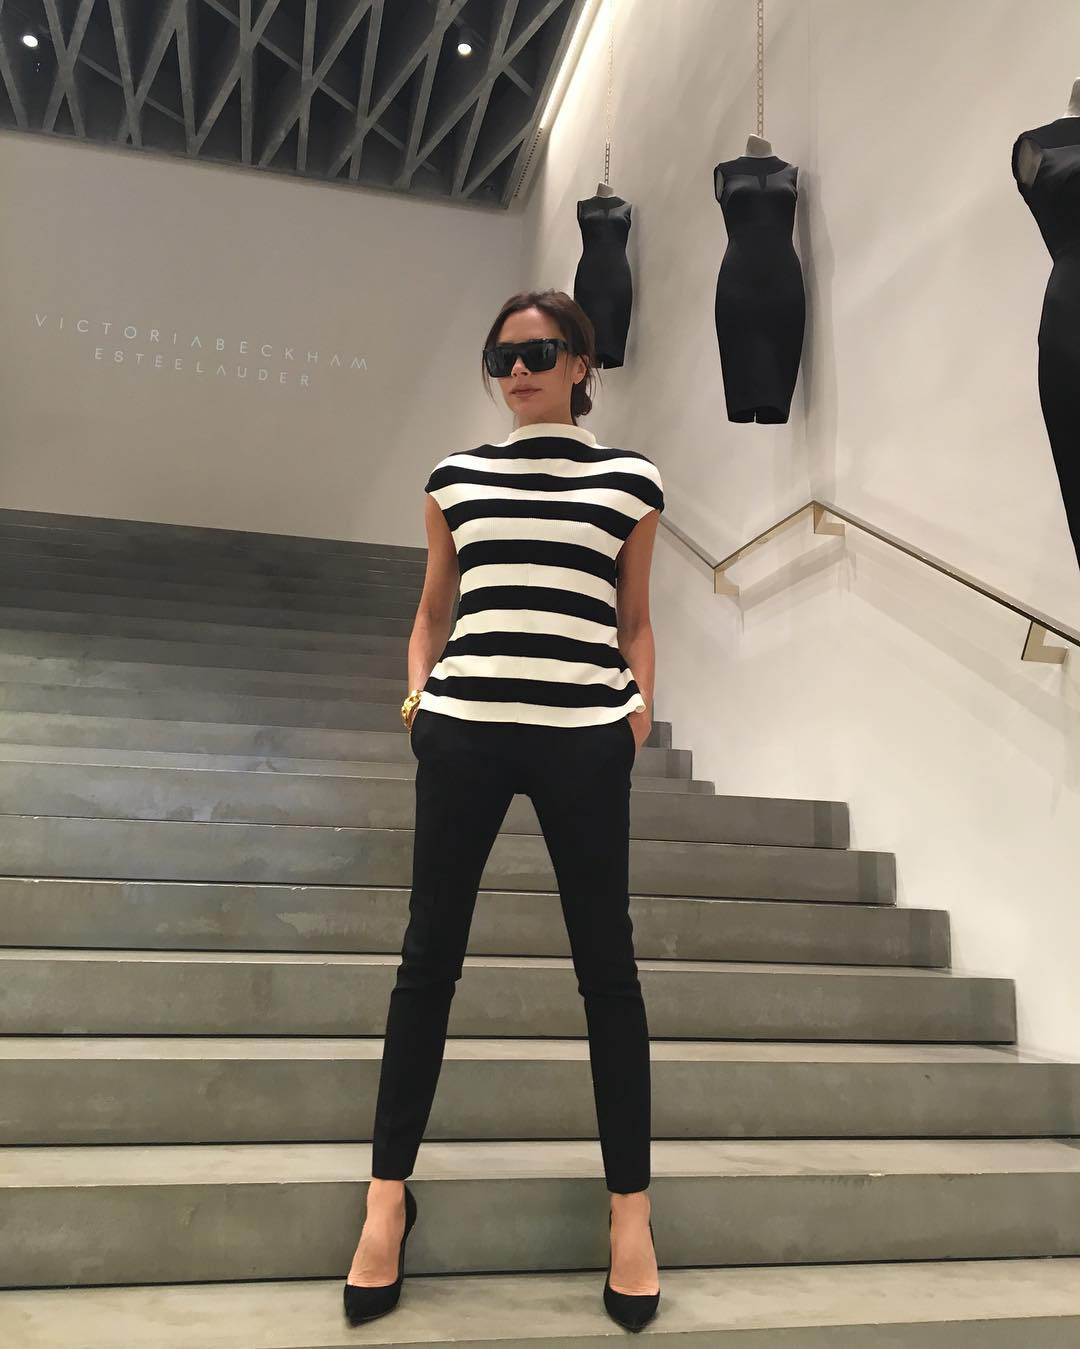

In [86]:
img

In [89]:
img_tensor = test_transform(img)
img_trans = img_tensor.as_in_context(context[0])
img_unsqueeze = img_trans.reshape(1,*img_trans.shape)

In [90]:
vector = net.extract(img_unsqueeze)

In [91]:
vector = vector.asnumpy()

In [92]:
host = "https://alpha-nnsearch.aidigger.com/api/v1/"

In [93]:
model = "image_metric_taobao128"
path = 'model/'+model+'/'

In [103]:
result = requests.post(host+path+'search',json={'vector':convert_vector_to_ascii(vector),'topk':20}).json()


In [101]:
ret = requests.post(host + path +"search/setting",json={'query_param':{'nprobe':20}})

In [102]:
ret.json()

{'info': 'set nprobe successfully'}

In [104]:
ids = [item['id'] for item in result]

In [105]:
 docs=requests.post(host+path+'mget',json={'ids':ids,
                                     'doc_types':['image','image']}).json()

In [106]:
doc_list = docs['docs']
image_url = []
for doc in doc_list:
    image_url.append(doc['_source']['cdn_url'])
pprint(image_url)

['https://cdn.aidigger.com/images/instagram/f95f00da22a2e143e6e457b10544a120.jpeg',
 'https://cdn.aidigger.com/images/instagram/f95f00da22a2e143e6e457b10544a120.jpeg',
 'https://cdn.aidigger.com/images/instagram/b26ced751a9a4b176c76770a65686df9.jpeg',
 'https://cdn.aidigger.com/images/instagram/b26ced751a9a4b176c76770a65686df9.jpeg',
 'https://cdn.aidigger.com/images/instagram/4d14ea6b31e811bdd1e5a9fc259f3d19.jpeg',
 'https://cdn.aidigger.com/images/instagram/90b549831d4eeb51304b29bb60c83d86.jpeg',
 'https://cdn.aidigger.com/images/instagram/1b33a2a3b49af2e0751885bfe9afe053.jpeg',
 'https://cdn.aidigger.com/images/instagram/cf551b64127a06828a1f7175110d7cce.jpeg',
 'https://cdn.aidigger.com/images/instagram/80945118843459fa63b1d449ac7df369.jpeg',
 'https://cdn.aidigger.com/images/instagram/f4d3edf43f4d466cc62930fdc5380216.jpeg',
 'https://cdn.aidigger.com/images/instagram/f4d3edf43f4d466cc62930fdc5380216.jpeg',
 'https://cdn.aidigger.com/images/instagram/267fa6f1bce7bdf06e48adfdb2c1440c

In [81]:
import matplotlib.pyplot as plt

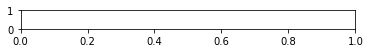

In [98]:
fig =plt.figure()
plt.subplot(10,1,1)

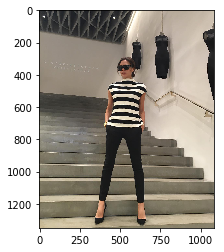

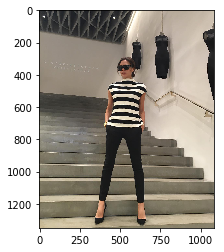

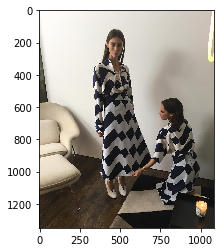

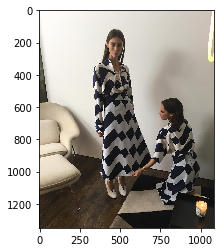

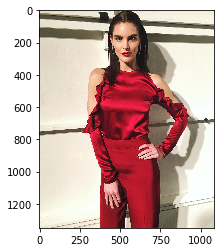

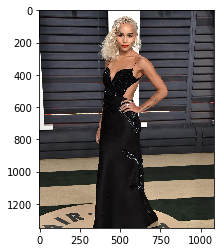

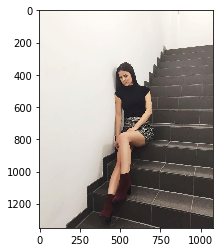

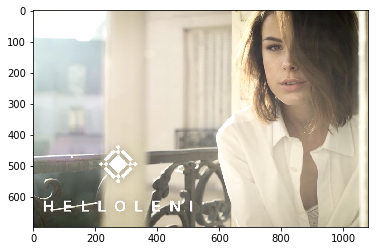

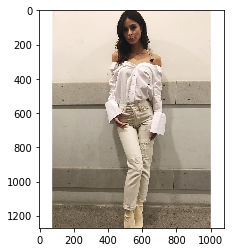

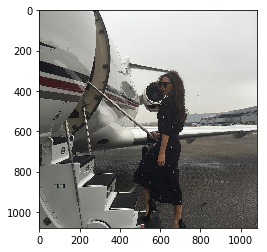

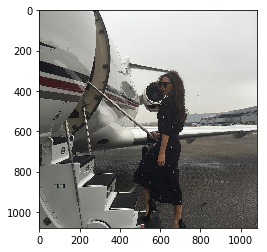

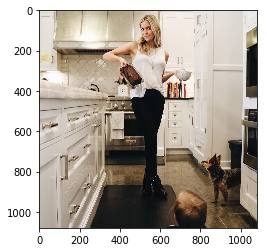

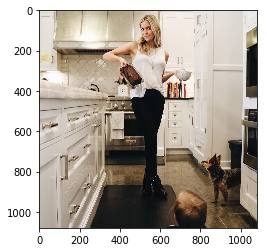

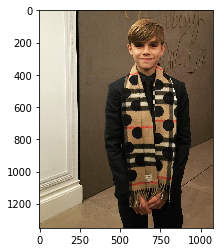

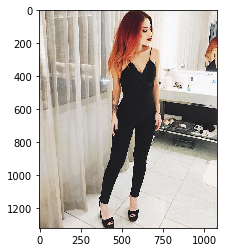

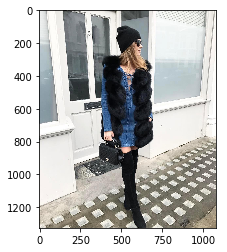

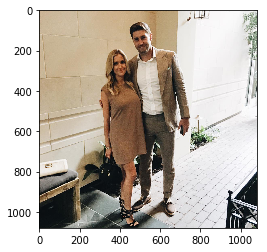

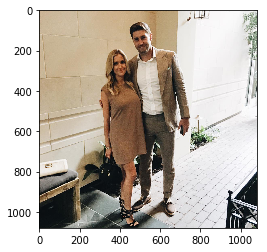

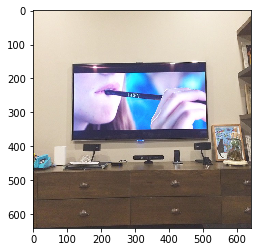

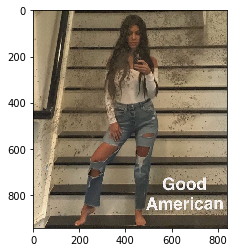

In [107]:
for i,url in enumerate(image_url):
    ret = requests.get(url)
    if ret.status_code !=200:
        print("failed",i)
        continue
    f = BytesIO()
    f.write(ret.content)
    pil_img = Image.open(f)
    np_img = np.asarray(pil_img)
    plt.figure(i+2)
    plt.imshow(np_img,imlim=800)
    

In [65]:
ret = requests.get(image_url[1])